<a href="https://colab.research.google.com/github/apasagic/Aerodynamics-Fluid-dynamics/blob/main/Drum_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import random
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Bidirectional, Dropout, TimeDistributed, Activation, Input, Reshape, Lambda, RepeatVector

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder

Mounted at /content/drive


In [ ]:
# Define constants
#SR = 22050
#DURATION = 1  # in seconds
WINDOW_SIZE = 0.025  # in seconds (100 ms)
HOP_SIZE = 0.05  # in seconds (50 ms)
N_FFT = 2048

In [ ]:
# Load representative 4 samples of each drum category

file_path_kick = '/content/drive/My Drive/Drum_samples/kick/Bass Sample 1.wav'
file_path_overhead = '/content/drive/My Drive/Drum_samples/overheads/Overhead Sample 1.wav'
file_path_snare = '/content/drive/My Drive/Drum_samples/snare/Snare Sample 1.wav'
file_path_tom = '/content/drive/My Drive/Drum_samples/toms/Tom Sample 1.wav'

audio_kick, sr = librosa.load(file_path_kick,mono=True)
audio_overhead, sr = librosa.load(file_path_overhead, mono=True)
audio_snare, sr = librosa.load(file_path_snare, mono=True)
audio_tom, sr = librosa.load(file_path_tom, mono=True)

len_audio = len(audio_overhead)

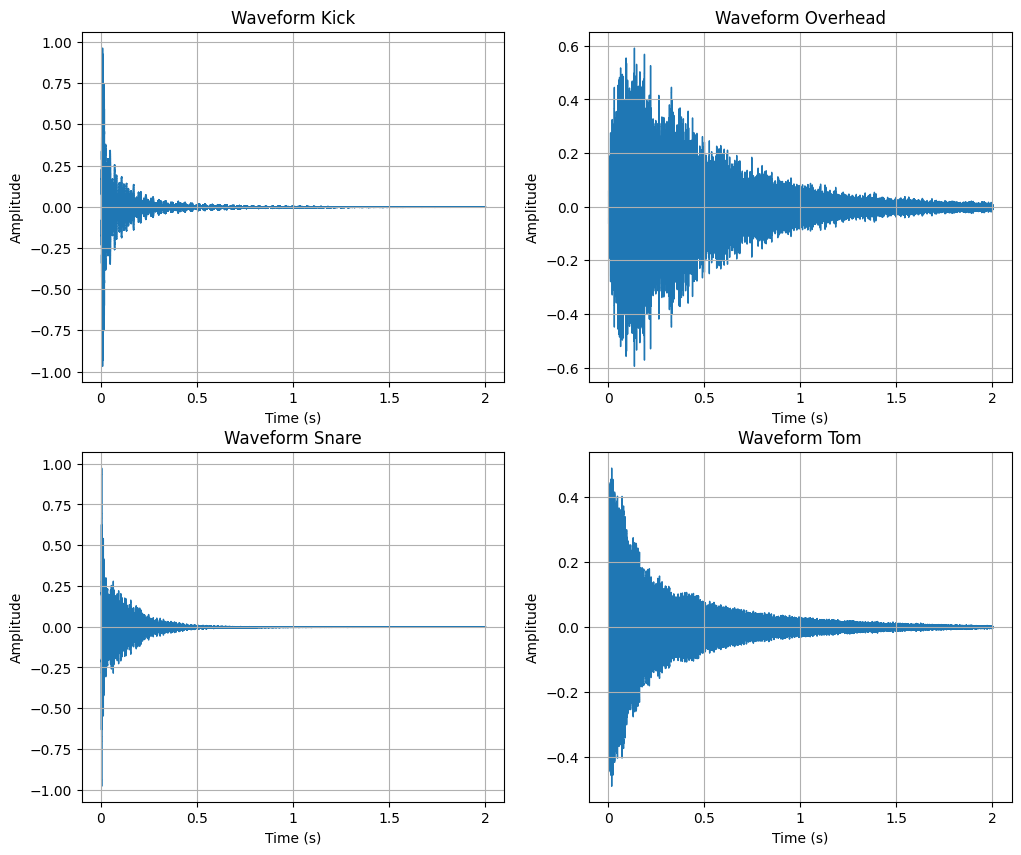

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (12,10))

# Plot the waveform (time domain)
#plt.figure(figsize=fig_size)
librosa.display.waveshow(audio_kick, sr=sr, ax = axs[0,0])
axs[0,0].set_title('Waveform Kick')
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].grid(True)

# Plot the waveform (time domain)
librosa.display.waveshow(audio_overhead, sr=sr, ax = axs[0,1])
axs[0,1].set_title('Waveform Overhead')
axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_ylabel('Amplitude')
axs[0,1].grid(True)

# Plot the waveform (time domain)
librosa.display.waveshow(audio_snare, sr=sr, ax = axs[1,0])
axs[1,0].set_title('Waveform Snare')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Amplitude')
axs[1,0].grid(True)

# Plot the waveform (time domain)
librosa.display.waveshow(audio_tom, sr=sr, ax = axs[1,1])
axs[1,1].set_title('Waveform Tom')
axs[1,1].set_xlabel('Time (s)')
axs[1,1].set_ylabel('Amplitude')
axs[1,1].grid(True)

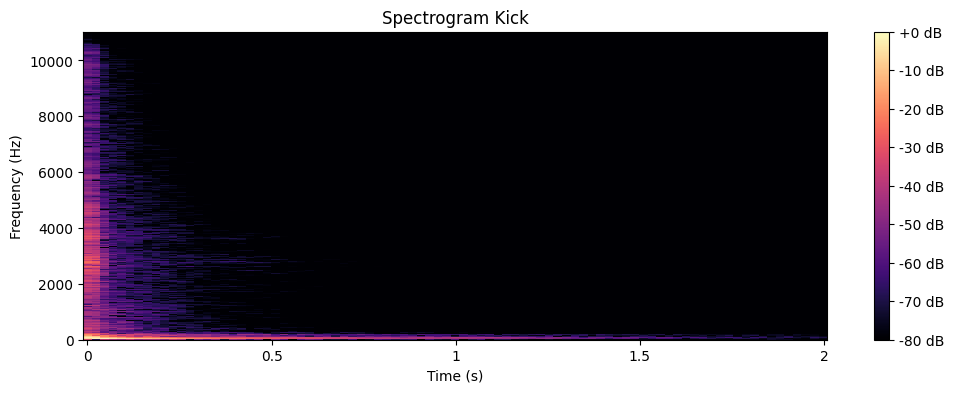

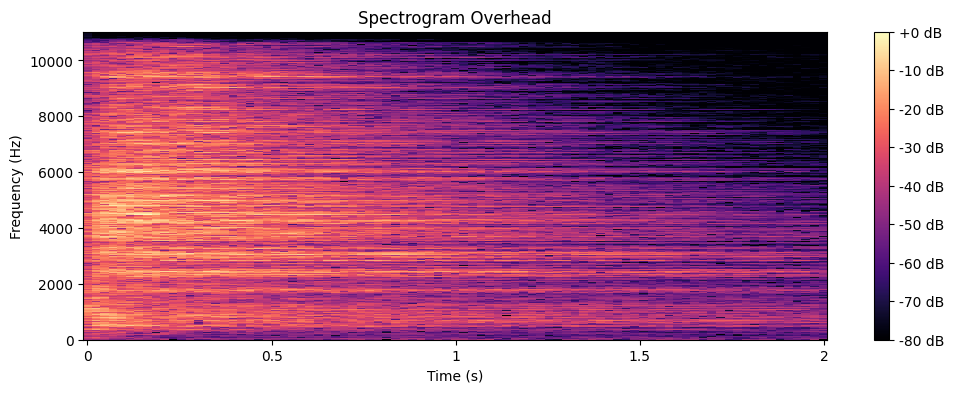

In [ ]:
# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(audio_kick)
magnitude, phase = librosa.magphase(D)

# Convert magnitude to decibels
magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)

# Plot the spectrogram of a Kick Drum (frequency domain)
plt.figure(figsize=(12, 4))
librosa.display.specshow(magnitude_db, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Kick')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

D = librosa.stft(audio_overhead)
magnitude, phase = librosa.magphase(D)

# Convert magnitude to decibels
magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)

# Plot the spectrogram of an Overhead (frequency domain)
plt.figure(figsize=(12, 4))
librosa.display.specshow(magnitude_db, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Overhead')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [ ]:
# In this part, code itterates though a given folder structure, and makes a list
# of all the file names contained in the folder/subfolder structure.
# List is then randomized for later division into Train/Test dataset
#
# Wave files are loaded and converted into a STFT representation in decibel,
# and resulting array that has Tx timesample times 1025 frequency bins is
# transposed and concatenated vertically to be later used as input tensor for RNN.
#
# Similarly Y is added a target label for each instrument based on folder name
# This has to be repeated for each timestep to be used in unfolded RNN
# Optionally periods of silence can be added as fifth category 'None'

# Local path to drum sample dir
directory = "/content/drive/My Drive/Drum_samples/"

# Init file list
list_files = []

# Ammount of data to be used for testing
test_perc = 0.1

#Itterate thru folder structure and get a file name list
for root, dirs, files in os.walk(directory):
  for file in files:

    if file.endswith(".wav"):

      file_path = os.path.join(root, file)
      list_files.append(file_path)

# Randomize the file list
random.shuffle(list_files)

# Initialize the arrays to be filled later with actual values with one row of 0
# This is later to be deleted for dimension consistency

X_train = np.zeros((1, int(1+N_FFT/2) ))
X_test = np.zeros((1, int(1+N_FFT/2) ))

# Get number of files in total
len_list = len(list_files)

# Init target variable lists
y_train = []
y_train_plot = []
y_test = []

# Define minimum and maximum length for period of silence
sil_dur_min, sil_dur_max = 1,10

# Itterate thru file structure
for x, file_path in enumerate(list_files):

      # Load audio files
      audio, sr = librosa.load(file_path, mono=True)

      # Calculated STFT, and get corresponding magntiude spectrum in DB
      stft = librosa.stft(audio, n_fft=N_FFT, hop_length=int(HOP_SIZE * sr))
      magnitude, phase = librosa.magphase(stft)
      magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)

      # Get a label Y from a file name
      label = os.path.basename(os.path.dirname(file_path))  # Assuming each subdirectory represents a class

      # For first 80 files in the randomized list add to train set
      if(x <int(len_list*(1-test_perc))):

        # Append an array of Magnitudes_DB generated by STFT (transposed - columns = freq_bins)
        #X_train = np.vstack((X_train, magnitude_db.T))
        X_train = np.stack((X_train, magnitude_db.T),axis = 0)

        #Fix to generate folded network
        y_train.append(label)

        # Append a label Y for each timestep in magnitude vector
        for i in range(magnitude_db.shape[1]):
           y_train_plot.append(label)
        # Uncomment for unfolded netwtork
           #y_train.append(label)

        #Add random period of silence in length of 10-100 samples
        #for j in range(random.randint(sil_dur_min, sil_dur_max)):
        #  X_train = np.vstack((X_train, -80*np.ones((1,magnitude_db.shape[0])) ))
        #  y_train.append('None')

      # For last 20 files in the randomized list add to test set
      else:

        # Append an array of Magnitudes_DB generated by STFT (transposed - columns = freq_bins)
        #X_test = np.vstack((X_test, magnitude_db.T))
        X_test = np.stack((X_test, magnitude_db.T),axis = 0)

        # Append a label Y for each timestep in magnitude vector
        y_test.append(label)

        # Append a label Y for each timestep in magnitude vector
        #for y in range(magnitude_db.shape[1]):
          #y_test.append(label)

        #Add random period of silence in length of 10-100 samples
        #for j in range(random.randint(sil_dur_min, sil_dur_max)):
        #  X_test = np.vstack((X_test, -80*np.ones((1,magnitude_db.shape[0])) ))
        #  y_test.append('None')

# Drop the first row in X_train and X_test
X_train = np.delete(X_train,0, axis=0)
X_test = np.delete(X_test,0, axis=0)

ValueError: all input arrays must have the same shape

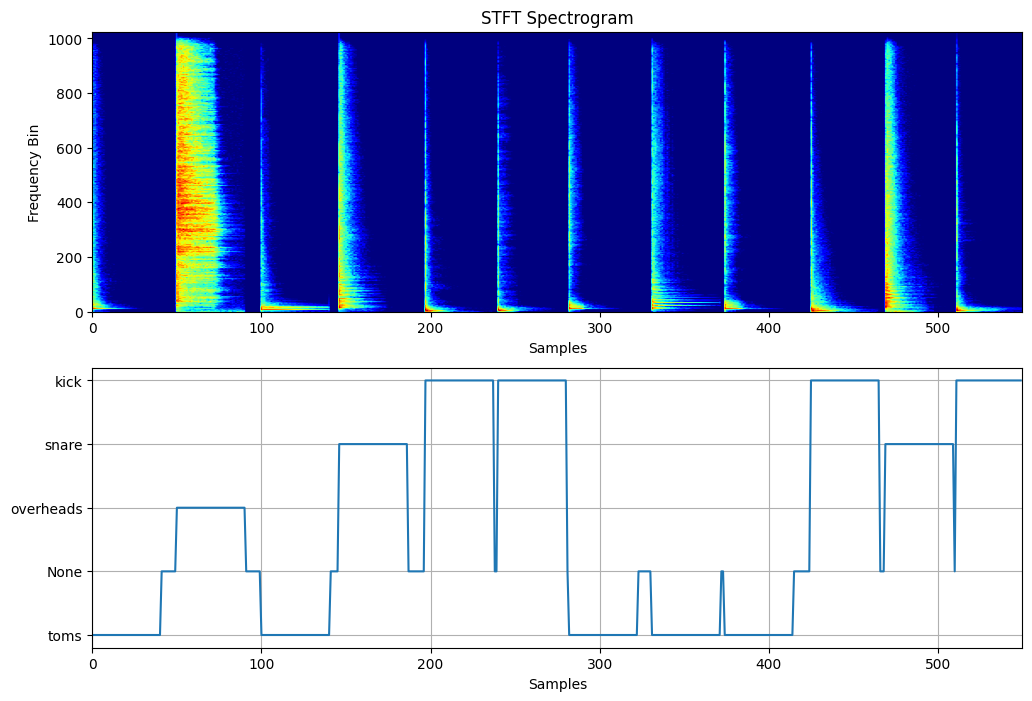

In [ ]:
# Set a length of plot window in samples
Plot_Window = 550

# Create subplots
fig, axs = plt.subplots(2, figsize=(12, 8))

# Plot the spectrogram on the first subplot
img = axs[0].imshow(X_train[:Plot_Window, :].T, aspect='auto', origin='lower', cmap='jet')

# Add colorbar to the plot
#plt.colorbar(img, ax=axs[0], label='Magnitude')

# Set labels and title for the first subplot
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Frequency Bin')
axs[0].set_title('STFT Spectrogram')
axs[0].set_xlim(0, Plot_Window)

axs[1].plot(y_train[:Plot_Window])
axs[1].set_xlabel('Samples')
#axs[1].set_title('Drug labels')
axs[1].set_xlim(0, Plot_Window)
axs[1].grid(True)

# Show the plot
plt.show()

In [ ]:
# Encode labels into one-hot vectors
encoder = OneHotEncoder(sparse_output=False)
y_train_OH = encoder.fit_transform(np.array(y_train).reshape(-1, 1))

# Create input output tensors
X = X_train.reshape((-1,X_train.shape[0],X_train.shape[1]))
Y = y_train_OH.reshape((-1,y_train_OH.shape[0],y_train_OH.shape[1]))

# Print shape of Input/Output vector for training for check
print(X.shape)
print(Y.shape)

# Use the same encoder to transform the test data
y_test_OH = encoder.transform(np.array(y_test).reshape(-1, 1))

X_val = X_test.reshape((-1,X_test.shape[0],X_test.shape[1]))
Y_val = y_test_OH.reshape((-1,y_test_OH.shape[0],y_test_OH.shape[1]))

# Print shape of Input/Output vector for training for check
print(X_val.shape)
print(Y_val.shape)

(1, 6673, 1025)
(1, 6673, 5)
(1, 724, 1025)
(1, 724, 5)


In [ ]:
# First version of the model is a NN with two LSTM layers similar to the one
# in the article, however, with Unidirectional layers as I do not see the need
# for bidirectionality in solving this problem as it seems to be the time
# decay of spectral components should suffice to say which drum is in question

# Define the LSTM model
model = Sequential()
model.add(SimpleRNN(units=250, input_shape=(None, X.shape[2]), return_sequences=True))  # n_timesteps is the number of time samples, n_features is the number of frequency bins
#model.add(LSTM(units=100, return_sequences=True, activation='tanh'))  # n_timesteps is the number of time samples, n_features is the number of frequency bins
model.add(TimeDistributed(Dense(units=5, activation='softmax')))  # num_classes is the number of drum types

# Early stop is used to make sure model is not overfitting. If 'val_loss' is not improved within 10 epochs (patience=10), the training is automaticlly stopped.
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.03)  # Adjust the learning rate as needed
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.fit(X, Y,  validation_data=(X_val,Y_val), verbose=1,callbacks=[early], epochs=200 )

Epoch 1/200
1/1 [==============================] - 183s 183s/step - loss: 2.3746 - accuracy: 0.1972 - val_loss: 7.7127 - val_accuracy: 0.3964
Epoch 2/200
1/1 [==============================] - 5s 5s/step - loss: 8.0825 - accuracy: 0.2028 - val_loss: 7.8516 - val_accuracy: 0.0566
Epoch 3/200
1/1 [==============================] - 6s 6s/step - loss: 5.2932 - accuracy: 0.2396 - val_loss: 10.0550 - val_accuracy: 0.1133
Epoch 4/200
1/1 [==============================] - 6s 6s/step - loss: 7.1361 - accuracy: 0.2335 - val_loss: 11.1849 - val_accuracy: 0.1133
Epoch 5/200
1/1 [==============================] - 5s 5s/step - loss: 8.0965 - accuracy: 0.2335 - val_loss: 9.6612 - val_accuracy: 0.1133
Epoch 6/200
1/1 [==============================] - 7s 7s/step - loss: 6.3738 - accuracy: 0.2335 - val_loss: 9.0708 - val_accuracy: 0.0566
Epoch 7/200
1/1 [==============================] - 5s 5s/step - loss: 6.0180 - accuracy: 0.2396 - val_loss: 8.3716 - val_accuracy: 0.0566
Epoch 8/200
1/1 [===========

In [ ]:
# Literal copy from the article - DO NOT ANALYSE THIS TOO MUCH

'''###### TRAIN 2: Bidirectional LSTM - 2 layers - 500 unis per layer ######'''
# Define Hyperparameter
number_units = 250
number_layers = 2
number_classes = 5
num_epochs = 200
batch_size = 40


# Define the optimizer with a specific learning rate
optimizer2 = Adam(learning_rate=0.01)  # Adjust the learning rate as needed

print ('Build model...')
# sequential methodology allows you to easily stack layers into your network without worrying too much about all the tensors
model2 = Sequential()

model2.add(Bidirectional(LSTM(units=number_units, input_shape=(X.shape[1], X.shape[2]), return_sequences=True)))
# Add two BiLSTM hidden layers
model.add(Bidirectional(LSTM(number_units, return_sequences=True, activation='tanh')))
# a dropout layer to prevent overfitting.
model.add(Dropout(0.25))

print("Adding classification layer")
# TimeDistributed adds an independent layer for each time step in the recurrent model.
# The TimeDistributed layer creates a vector of length equal to the number of features outputted from the previous layer.
model2.add(TimeDistributed(Dense(number_classes)))
model2.add(Activation('sigmoid'))

# Compile model: binary crossentroypy are used as loss and metrics. The metrics are used to check the improvement of model during training
model2.compile(loss='categorical_crossentropy', optimizer=optimizer2, metrics=['accuracy'])



Build model...
Adding classification layer


In [ ]:

print ('Train . . .')
# Start training model with given batch size, train/validation data and labels, number of epochs
# callback argument here include checkpoint to save model after each epochs, early to check whether model meets the early stop criteria and needs to stop even not reaching epochs,
# plot_losses a function to plot train and validation loss after each epoch
save = model2.fit(X, Y, batch_size = 1, validation_data=(X_val,Y_val), epochs = num_epochs, verbose=1,callbacks=[early])
training_log.write(str(save.history) + "\n")
training_log.close()

Train . . .
Epoch 1/200
1/1 [==============================] - 48s 48s/step - loss: 1.7819 - accuracy: 0.1830 - val_loss: 4.8789 - val_accuracy: 0.1095
Epoch 2/200
1/1 [==============================] - 40s 40s/step - loss: 4.3018 - accuracy: 0.2309 - val_loss: 3.2679 - val_accuracy: 0.1095
Epoch 3/200
1/1 [==============================] - 49s 49s/step - loss: 2.9213 - accuracy: 0.2309 - val_loss: 2.1181 - val_accuracy: 0.1095
Epoch 4/200
1/1 [==============================] - 56s 56s/step - loss: 2.0020 - accuracy: 0.2309 - val_loss: 1.6852 - val_accuracy: 0.2724
Epoch 5/200
1/1 [==============================] - 45s 45s/step - loss: 1.7539 - accuracy: 0.2127 - val_loss: 1.6102 - val_accuracy: 0.2737
Epoch 6/200
1/1 [==============================] - 41s 41s/step - loss: 1.7852 - accuracy: 0.2127 - val_loss: 1.6723 - val_accuracy: 0.2190
Epoch 7/200
1/1 [==============================] - 43s 43s/step - loss: 1.9262 - accuracy: 0.2187 - val_loss: 1.7543 - val_accuracy: 0.2190
Epoch 8/

NameError: name 'training_log' is not defined

In [ ]:
D = librosa.stft(audio_overhead)
magnitude, phase = librosa.magphase(D)

# Convert magnitude to decibels
magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)
magnitude_db = magnitude_db.T
magnitude_db = magnitude_db.reshape(1,magnitude_db.shape[0],magnitude_db.shape[1])
print(magnitude_db.shape)


pred = model.predict(magnitude_db)

#print(pred)

max_indices  = np.argmax(pred, axis=-1)
#print(max_indices)

# Create a one-hot representation for each sequence
one_hot_output = np.eye(pred.shape[-1])[max_indices]

#print(one_hot_output)

# Inverse transform the predicted classes to get the original class labels
predicted_class_names = encoder.inverse_transform(one_hot_output.reshape(one_hot_output.shape[1],one_hot_output.shape[2]))

print("Predicted class names:", predicted_class_names)

(1, 87, 1025)
1/1 [==============================] - 0s 142ms/step
Predicted class names: [['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']
 ['kick']]
